In [0]:
import os
!rm -rf *
!rm -rf .kaggle/
!git clone https://github.com/bkahn-github/data-science-bowl.git
!pip install -r data-science-bowl/requirements.txt
!pip3 install http://download.pytorch.org/whl/cu80/torch-0.3.0.post4-cp36-cp36m-linux_x86_64.whl 
!pip3 install torchvision
!pip3 install Pillow
!mkdir ~/.kaggle
f = open(".kaggle/kaggle.json", "w")
f.write('{"username":"bkkaggle","key":"bf4e62680116284087ace0484990f87a"}')
f.close()
!kaggle competitions download -c data-science-bowl-2018
!unzip ~/.kaggle/competitions/data-science-bowl-2018/stage1_train.zip -d ~/.kaggle/competitions/data-science-bowl-2018/train
!unzip ~/.kaggle/competitions/data-science-bowl-2018/stage1_test.zip -d ~/.kaggle/competitions/data-science-bowl-2018/test
!unzip ~/.kaggle/competitions/data-science-bowl-2018/stage1_train_labels.csv.zip -d ~/.kaggle/competitions/data-science-bowl-2018/labels
os.chdir('data-science-bowl/pytorchUnet')
!git checkout new-pytorch-unet

In [0]:
os.chdir('../../')
!rm -rf data-science-bowl/
!git clone https://github.com/bkahn-github/data-science-bowl.git
os.chdir('data-science-bowl/pytorchUnet')
!git checkout new-pytorch-unet

In [0]:
import PIL
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch.autograd import Variable
from torch.backends import cudnn

from tqdm import tqdm, tqdm_notebook

np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)

%matplotlib inline

from load_data import load_data
from metrics import dice_loss, iou
from model import UNet
from process_data import predict, encode, upsample
from visualize import show_val, show_test
from submit import submit

In [4]:
train, val, x_test_sizes, train_dataset, val_dataset, test_dataset, train_dataloader, val_dataloader, test_dataloader = load_data()

100%|██████████| 65/65 [00:00<00:00, 148.36it/s]


In [9]:
model = UNet(3, 1).cuda()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4)

for epoch in range(25):
  train_ious = []
  val_ious = []

  for x_train, y_train in tqdm(train_dataloader):
    x_train = Variable(x_train).cuda()
    y_train = Variable(y_train).cuda()

    optimizer.zero_grad()

    outputs = model(x_train)

    loss = dice_loss(outputs, y_train)
    train_iou, _ = iou((outputs.cpu().data.squeeze(0).numpy() > 0.5), y_train.cpu().data.numpy())
    train_ious.append(train_iou)

    loss.backward()
    optimizer.step()

  for x_val, y_val in tqdm(val_dataloader):
    x_val = Variable(x_val).cuda()
    y_val = Variable(y_val).cuda()

    optimizer.zero_grad()

    o = model(x_val)

    val_loss = dice_loss(o, y_val)
    val_iou, _ = iou((o.cpu().data.squeeze(0).numpy() > 0.5), y_val.cpu().data.numpy())
    val_ious.append(val_iou)

  print('\n')
  print(f'Epoch: {epoch + 1} Training Loss: {round(loss.data[0], 4)} Training IOU: {np.asarray(train_ious).mean()} Val Loss: {round(val_loss.data[0], 4)} Val IOU: {np.asarray(val_ious).mean()}', end='\n')


  0%|          | 0/134 [00:00<?, ?it/s]



Epoch: 1 Training Loss: 0.6125 Training IOU: 0.0029850746268656717 Val Loss: 0.7632 Val IOU: 0.0058823529411764705


  0%|          | 0/134 [00:00<?, ?it/s]



Epoch: 2 Training Loss: 0.5814 Training IOU: 0.004477611940298508 Val Loss: 0.7331 Val IOU: 0.008823529411764707


  0%|          | 0/134 [00:00<?, ?it/s]



Epoch: 3 Training Loss: 0.543 Training IOU: 0.013432835820895524 Val Loss: 0.7045 Val IOU: 0.014705882352941176


  0%|          | 0/134 [00:00<?, ?it/s]



Epoch: 4 Training Loss: 0.4982 Training IOU: 0.04402985074626866 Val Loss: 0.723 Val IOU: 0.0911764705882353


  0%|          | 0/134 [00:00<?, ?it/s]



Epoch: 5 Training Loss: 0.4385 Training IOU: 0.12611940298507465 Val Loss: 0.6345 Val IOU: 0.19117647058823528


  0%|          | 0/134 [00:00<?, ?it/s]



Epoch: 6 Training Loss: 0.4433 Training IOU: 0.19999999999999998 Val Loss: 0.5606 Val IOU: 0.19999999999999998


  0%|          | 0/134 [00:00<?, ?it/s]



Epoch: 7 Training Loss: 0.3575 Training IOU: 0.2343283582089552 Val Loss: 0.5306 Val IOU: 0.19705882352941176


  0%|          | 0/134 [00:00<?, ?it/s]



Epoch: 8 Training Loss: 0.3657 Training IOU: 0.2798507462686567 Val Loss: 0.541 Val IOU: 0.261764705882353


  0%|          | 0/134 [00:00<?, ?it/s]



Epoch: 9 Training Loss: 0.3695 Training IOU: 0.3276119402985075 Val Loss: 0.5106 Val IOU: 0.31470588235294117


  0%|          | 0/134 [00:00<?, ?it/s]



Epoch: 10 Training Loss: 0.3019 Training IOU: 0.3402985074626866 Val Loss: 0.5214 Val IOU: 0.3470588235294118


  0%|          | 0/134 [00:00<?, ?it/s]



Epoch: 11 Training Loss: 0.2873 Training IOU: 0.391044776119403 Val Loss: 0.5 Val IOU: 0.4264705882352941


  0%|          | 0/134 [00:00<?, ?it/s]



Epoch: 12 Training Loss: 0.2757 Training IOU: 0.43582089552238806 Val Loss: 0.4567 Val IOU: 0.4352941176470588


  0%|          | 0/134 [00:00<?, ?it/s]



Epoch: 13 Training Loss: 0.2214 Training IOU: 0.4753731343283582 Val Loss: 0.4412 Val IOU: 0.5029411764705882


  0%|          | 0/134 [00:00<?, ?it/s]



Epoch: 14 Training Loss: 0.1826 Training IOU: 0.47761194029850756 Val Loss: 0.412 Val IOU: 0.4617647058823529


  0%|          | 0/134 [00:00<?, ?it/s]



Epoch: 15 Training Loss: 0.1751 Training IOU: 0.5014925373134329 Val Loss: 0.3913 Val IOU: 0.5029411764705882


  0%|          | 0/134 [00:00<?, ?it/s]



Epoch: 16 Training Loss: 0.1552 Training IOU: 0.5186567164179104 Val Loss: 0.2904 Val IOU: 0.55


  0%|          | 0/134 [00:00<?, ?it/s]



Epoch: 17 Training Loss: 0.1689 Training IOU: 0.5238805970149253 Val Loss: 0.2903 Val IOU: 0.5323529411764706


  0%|          | 0/134 [00:00<?, ?it/s]



Epoch: 18 Training Loss: 0.15 Training IOU: 0.5507462686567165 Val Loss: 0.29 Val IOU: 0.5235294117647059


  0%|          | 0/134 [00:00<?, ?it/s]



Epoch: 19 Training Loss: 0.1193 Training IOU: 0.5477611940298508 Val Loss: 0.2778 Val IOU: 0.5647058823529413


  0%|          | 0/134 [00:00<?, ?it/s]



Epoch: 20 Training Loss: 0.1386 Training IOU: 0.5455223880597017 Val Loss: 0.3131 Val IOU: 0.5441176470588235


  0%|          | 0/134 [00:00<?, ?it/s]



Epoch: 21 Training Loss: 0.1281 Training IOU: 0.5664179104477612 Val Loss: 0.3237 Val IOU: 0.5882352941176471


  0%|          | 0/134 [00:00<?, ?it/s]



Epoch: 22 Training Loss: 0.1163 Training IOU: 0.5716417910447761 Val Loss: 0.2656 Val IOU: 0.5794117647058824


  0%|          | 0/134 [00:00<?, ?it/s]



Epoch: 23 Training Loss: 0.1174 Training IOU: 0.582089552238806 Val Loss: 0.2018 Val IOU: 0.6058823529411765


  0%|          | 0/134 [00:00<?, ?it/s]



Epoch: 24 Training Loss: 0.1471 Training IOU: 0.582089552238806 Val Loss: 0.2219 Val IOU: 0.5794117647058823


100%|██████████| 34/34 [00:02<00:00, 11.90it/s]



Epoch: 25 Training Loss: 0.1092 Training IOU: 0.5992537313432836 Val Loss: 0.2492 Val IOU: 0.6000000000000001


0.8


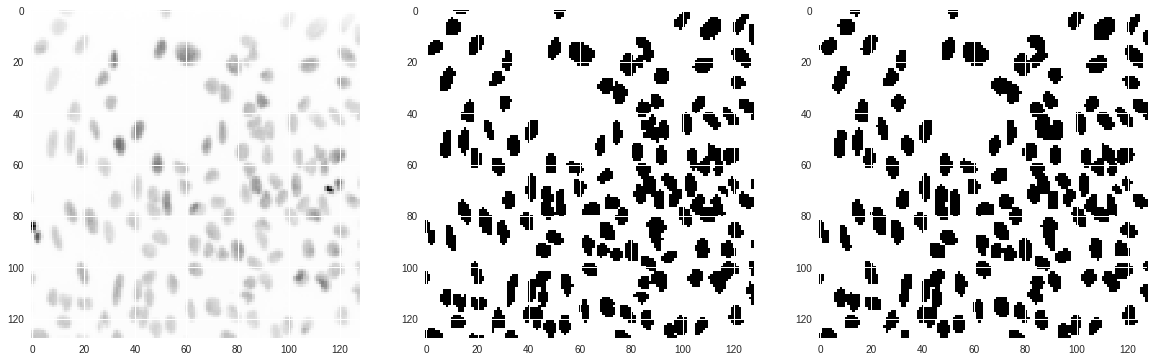

In [10]:
show_val(1, model, iou, val_dataset)

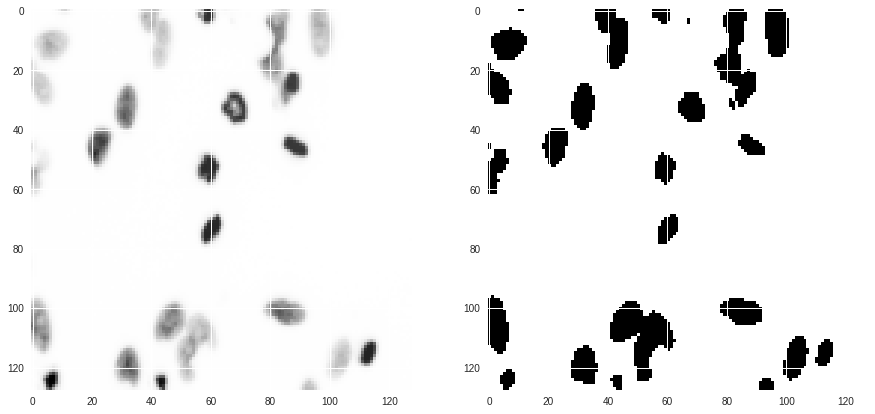

In [11]:
show_test(1, model, test_dataset)

In [12]:
preds = predict(model, test_dataset, test_dataloader, optimizer)

65it [00:01, 44.44it/s]


In [0]:
preds_upsampled = upsample(preds)

In [0]:
test_path = '../../.kaggle/competitions/data-science-bowl-2018/test/'
test_ids = next(os.walk(test_path))[1]

rles, new_test_ids = encode(preds_upsampled, test_ids)

In [0]:
submit(new_test_ids, rles)

In [0]:
pd.read_csv('./submission.csv')

In [0]:
from google.colab import files

files.download('submission.csv')